# Time Series Forecasting

Author: Charles Liu

This notebook includes the data preprocessing, model creation, training, testing and visualizations

This forecasting model can be treated in two ways:
  1. Regression: predict the close price of the next day, where the price is numeric.
  2. Classification: predict the future close return to positive or negative

## Part I. Close Price Forecasting

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


TICKER = 'ANZ'
MISSING_VALUE_STRAGETY = 'interpolate'

## Prepare data

### Select a ticker and read the data to data frame

In [2]:
# Read dataframe. Here only a dates with valid data of the selected ticker is read
from pricedata import read_stock_data, read_dates
df_raw = read_stock_data(TICKER)

print("Raw data shape:",  df_raw.shape)
df_raw.head()

Raw data shape: (882, 5)


,open,high,low,close,volume
date,,,,,
2015-01-02,32.09,32.29,31.91,32.23,1925826
2015-01-05,32.21,32.41,32.00,32.17,2507257
2015-01-06,31.84,32.01,31.59,31.78,4771084
2015-01-07,31.78,31.91,31.46,31.72,4039936
2015-01-08,31.92,32.09,31.70,31.91,3043671


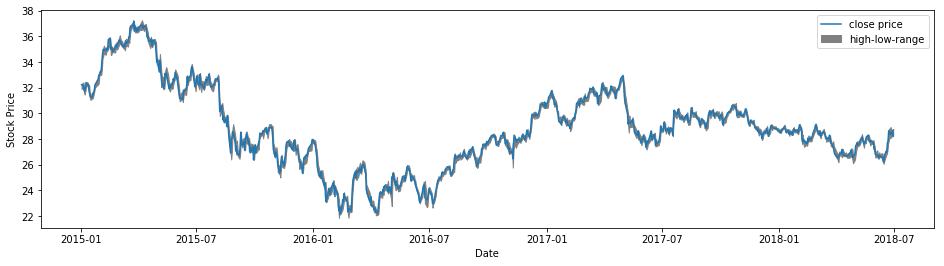

In [3]:
# Visualize the raw data. We see the the variance of the prices on a day is much smaller than the prices across time.
df = df_raw
fig = plt.figure(figsize=(16, 4))
plt.plot(df.index, df['close'], "-", label='close price')
plt.fill_between(df.index, y1=df['low'], y2=df['high'], color='gray', label='high-low-range')
plt.xlabel("Date")
plt.ylabel('Stock Price')
plt.legend()
plt.show()
plt.close()

### Handling missing data.

A number of missing value handling methods are tested. The 

In [4]:
# Raw data is directed used in which missing values are ignored.
if MISSING_VALUE_STRAGETY is None:
    df_full = df_raw

In [5]:
if MISSING_VALUE_STRAGETY == 'mean':
    dates = read_dates()
    if len(dates) > len(df_raw):
        df_full = pd.DataFrame(index=dates, columns=df_raw.columns, dtype=float)
        df_full.loc[df_raw.index] = df_raw.astype(float)


    # Discard the dates before the first valid data
    df_full = df_full.loc[df_raw.index[0]:]

    print("Raw data shape:",  df_full.shape)

    df_full.head()

In [6]:
if MISSING_VALUE_STRAGETY == 'mean':
    # Read full trading dates and create a dataframe with full trading dates. 
    from sklearn.preprocessing import Imputer
    imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)
    imputer.fit(df_raw.values)

    X = imputer.transform(df_full.values)
    df_full = pd.DataFrame(X, index=df_full.index, columns=df_full.columns)
    df_full.head()

In [7]:
if MISSING_VALUE_STRAGETY == 'interpolate':
    # Read full trading dates and create a dataframe with full trading dates. 
    dates = read_dates()
    if len(dates) > len(df_raw):
        df_full = pd.DataFrame(index=dates, columns=df_raw.columns, dtype=float)
        df_full.loc[df_raw.index] = df_raw.astype(float)

    # Discard the dates before the first valid data
    df_full = df_full.loc[df_raw.index[0]:]
    df_full.shape

    # Fill the NaN with time interpolation
    if df_full.isna().sum().sum() > 0:
        df_full = df_full.interpolate(method='linear')
    df_full.head()

In [8]:
if MISSING_VALUE_STRAGETY == '0':
    # Read full trading dates and create a dataframe with full trading dates. 
    dates = read_dates()
    if len(dates) > len(df_raw):
        df_full = pd.DataFrame(data=0, index=dates, columns=df_raw.columns, dtype=float)
        df_full.loc[df_raw.index] = df_raw.astype(float)

    # Discard the dates before the first valid data
    df_full = df_full.loc[df_raw.index[0]:]
    df_full.head()

2. Scaling

For stock prices and trading volumes, the Min-Max scaler is an appropriate scaler. In contrast, the standard scaler will produce negative values which make no sense in this occasion.

In [9]:
from sklearn.preprocessing import MinMaxScaler as Scaler
scaler = Scaler(feature_range = (0, 1))
X = scaler.fit_transform(df_full.values)
df_scaled = pd.DataFrame(index=df_full.index, data=X, columns=df_full.columns)
df_scaled.head()

,open,high,low,close,volume
2015-01-02,0.665993,0.664638,0.674497,0.669554,0.000249
2015-01-05,0.674074,0.672752,0.680537,0.665556,0.019358
2015-01-06,0.649158,0.645707,0.653020,0.639574,0.093760
2015-01-07,0.645118,0.638945,0.644295,0.635576,0.069730
2015-01-08,0.654545,0.651116,0.660403,0.648235,0.036988


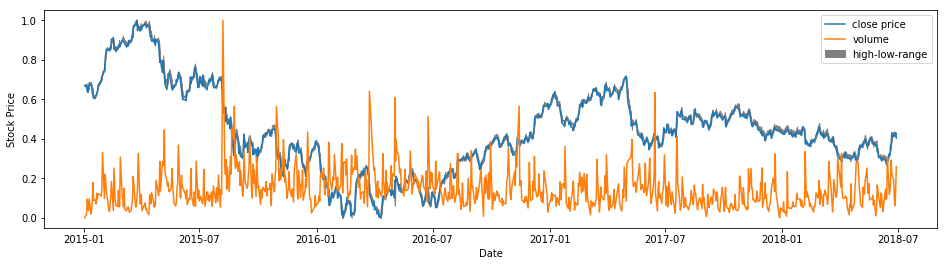

In [10]:
# Visualize the scaled data. 
df = df_scaled
fig = plt.figure(figsize=(16, 4))
plt.plot(df.index, df['close'], "-", label='close price')
plt.fill_between(df.index, y1=df['low'], y2=df['high'], color='gray', label='high-low-range')
plt.plot(df.index, df['volume'], label='volume')
plt.xlabel("Date")
plt.ylabel('Stock Price')
plt.legend()
plt.show()
plt.close()

### Prepare the training, validation and test data
Here are about my feature selection.
   1. Input features: The Open, high, low and high prices and the trading volume are used.
   2. Look back time: 5 days, i.e. totally 25 features will be used.
   3. Target feature: the close price of the next day

In [11]:
lookback = 5
features = 5
delay = 1

total_samples = len(df_full) - lookback - delay + 1
training_samples = int(total_samples * 0.6)
validation_samples = int(total_samples * 0.2)
test_samples = total_samples - training_samples - validation_samples

print("Total samples:", total_samples)
print("Training:", training_samples)
print("Validation:", validation_samples)
print("Test:", test_samples)

Total samples: 878
Training: 526
Validation: 175
Test: 177


In [12]:
from helpers import sample_generator, vectorize_input, vectorize_target

sample_generator = sample_generator(df_scaled, lookback=lookback, delay=delay, target_col=3)
sample_data = list(sample_generator)

# np.random.shuffle(sample_data)

X_data = vectorize_input(sample_data)
y_data = vectorize_target(sample_data)

X_train = X_data[:training_samples]
y_train = y_data[:training_samples]

X_valid = X_data[training_samples: training_samples + validation_samples]
y_valid = y_data[training_samples: training_samples + validation_samples]

X_test = X_data[training_samples + validation_samples: ]
y_test = y_data[training_samples + validation_samples: ]


X_train = X_train.reshape(X_train.shape[0], 1, lookback * features)
X_valid = X_valid.reshape(X_valid.shape[0], 1, lookback * features)
X_test = X_test.reshape(X_test.shape[0], 1, lookback * features)

X_train.shape

(526, 1, 25)

### A forecasting model using recurrent neural networks

In [13]:
from keras.models import Sequential
from keras import layers

units = 64

model = Sequential()

model.add(layers.LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.Dropout(rate=0.1))

model.add(layers.LSTM(units=units, return_sequences=True))
model.add(layers.Dropout(rate=0.1))

model.add(layers.LSTM(units=units, return_sequences=True))
model.add(layers.Dropout(rate=0.1))

model.add(layers.LSTM(units=units))
model.add(layers.Dropout(rate=0.1))

model.add(layers.Dense(units=units, activation='relu'))

model.add(layers.Dense(units=1))
    
model.compile(optimizer='adam', loss='mean_absolute_error')
history = model.fit(X_train, y_train, epochs=100, batch_size=lookback* features, validation_data=(X_valid, y_valid))

Using TensorFlow backend.
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 526 samples, validate on 175 samples
Epoch 1/100
526/526 [==============================] - 5s 10ms/step - loss: 0.3335 - val_loss: 0.1859
Epoch 2/100
526/526 [==============================] - 0s 701us/step - loss: 0.1333 - val_loss: 0.0348
Epoch 3/100
526/526 [==============================] - 0s 703us/step - loss: 0.0705 - val_loss: 0.0833
Epoch 4/100
526/526 [==============================] - 1s 1ms/step - loss: 0.0571 - val_loss: 0.0327
Epoch 5/100
526/526 [==============================] - 0s 710us/step - loss: 0.0517 - val_loss: 0.0416
Epoch 6/100
526/526 [==============================] - 0s 738us/step - loss: 0.0601 - val_loss: 0.0310
Epoch 7/100
526/526 [==============================] - 0s 721us/step - loss: 0.0510 - val_loss: 0.0343
Epoch 8/100
526/526 [==============================] - 0s 735us/step - loss: 0.0554 - val_loss: 0.0356
Epoch 9/100
5

526/526 [==============================] - 0s 808us/step - loss: 0.0307 - val_loss: 0.0193
Epoch 75/100
526/526 [==============================] - 0s 808us/step - loss: 0.0295 - val_loss: 0.0201
Epoch 76/100
526/526 [==============================] - 0s 822us/step - loss: 0.0303 - val_loss: 0.0210
Epoch 77/100
526/526 [==============================] - 1s 1ms/step - loss: 0.0361 - val_loss: 0.0517
Epoch 78/100
526/526 [==============================] - 0s 803us/step - loss: 0.0387 - val_loss: 0.0213
Epoch 79/100
526/526 [==============================] - 0s 805us/step - loss: 0.0292 - val_loss: 0.0209
Epoch 80/100
526/526 [==============================] - 0s 817us/step - loss: 0.0300 - val_loss: 0.0188
Epoch 81/100
526/526 [==============================] - 0s 830us/step - loss: 0.0310 - val_loss: 0.0193
Epoch 82/100
526/526 [==============================] - 1s 1ms/step - loss: 0.0355 - val_loss: 0.0208
Epoch 83/100
526/526 [==============================] - 0s 803us/step - loss: 0.0

regession error baseline:  0.012287263036763363
Mean absolute error:  0.20551026571517447


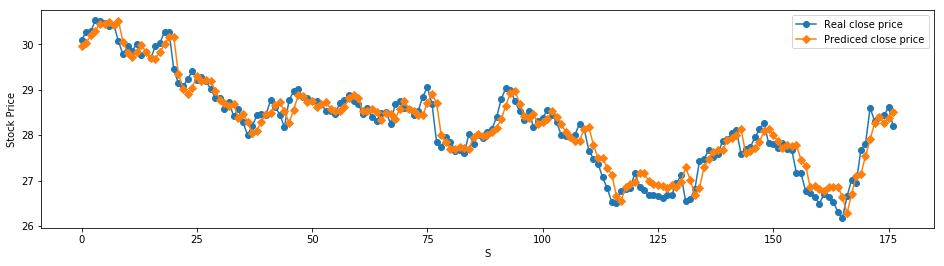

In [14]:
# The baseline error
baseline_regression_error = np.mean(np.abs(y_test[1:] - y_test[:-1]))
print("regession error baseline: ", baseline_regression_error)

# Predict the model
y_test_real = y_test
y_test_pred = model.predict(X_test).reshape(-1,)

# Inverse the scale
y_test_real = scaler.inverse_transform(np.array([y_test_real] * 5).transpose())[:,0]
y_test_pred = scaler.inverse_transform(np.array([y_test_pred] * 5).transpose())[:,0]

regression_error = np.mean(np.abs(y_test_real - y_test_pred))
print("Mean absolute error: ", regression_error)


# Visualize the raw data. We see the the variance of the prices on a day is much smaller than the prices across time.
fig = plt.figure(figsize=(16, 4))
plt.plot(y_test_real, "o-", label='Real close price')
#plt.plot(range(1, len(y_test_real) + 1), y_test_real, "s-", label='Real close price')
plt.plot(y_test_pred, "D-", label='Prediced close price')
plt.xlabel("S")
plt.ylabel('Stock Price')
plt.legend()
plt.show()
plt.close()

## Part II:  Binary classification of future close return

In [15]:
from keras.utils import to_categorical

def future_close_return(X, y):
    fcr =  y / X[:, 0, -2] - 1
    return fcr 
    
    
train_labels = future_close_return(X_train, y_train) > 0
valid_labels = future_close_return(X_valid, y_valid) > 0
test_labels = future_close_return(X_test, y_test) > 0


units = 64

classifier = Sequential()

classifier.add(layers.LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
classifier.add(layers.Dropout(rate=0.2))

classifier.add(layers.LSTM(units=units))
classifier.add(layers.Dropout(rate=0.2))

# classifier.add(layers.Dense(units, activation='relu'))

classifier.add(layers.Dense(1, activation='sigmoid'))
    
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
classification_history = classifier.fit(X_train, train_labels, epochs=100, batch_size=lookback * features,
                                        validation_data=(X_valid, valid_labels))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


Train on 526 samples, validate on 175 samples
Epoch 1/100
526/526 [==============================] - 3s 5ms/step - loss: 0.6930 - acc: 0.5019 - val_loss: 0.6931 - val_acc: 0.5029
Epoch 2/100
526/526 [==============================] - 0s 439us/step - loss: 0.6930 - acc: 0.5190 - val_loss: 0.6931 - val_acc: 0.5029
Epoch 3/100
526/526 [==============================] - 0s 457us/step - loss: 0.6931 - acc: 0.5228 - val_loss: 0.6934 - val_acc: 0.5029
Epoch 4/100
526/526 [==============================] - 0s 468us/step - loss: 0.6923 - acc: 0.5228 - val_loss: 0.6936 - val_acc: 0.5029
Epoch 5/100
526/526 [==============================] - 0s 469us/step - loss: 0.6936 - acc: 0.5209 - val_loss: 0.6932 - val_acc: 0.5029
Epoch 6/100
526/526 [==============================] - 0s 479us/step - loss: 0.6930 - acc: 0.5133 - val_loss: 0.6932 - val_acc: 0.5029
Epoch 7/100
526/526 [==============================] - 0s 476us/step - loss: 0.6925 - acc: 0.5209 - val_loss: 0.6935 - val_acc: 0.5029
Epoch 8/100

Epoch 61/100
526/526 [==============================] - 0s 477us/step - loss: 0.6889 - acc: 0.5323 - val_loss: 0.6924 - val_acc: 0.5200
Epoch 62/100
526/526 [==============================] - 0s 828us/step - loss: 0.6889 - acc: 0.5152 - val_loss: 0.6913 - val_acc: 0.5429
Epoch 63/100
526/526 [==============================] - 0s 475us/step - loss: 0.6896 - acc: 0.5323 - val_loss: 0.6905 - val_acc: 0.5371
Epoch 64/100
526/526 [==============================] - 0s 476us/step - loss: 0.6899 - acc: 0.5095 - val_loss: 0.6905 - val_acc: 0.5371
Epoch 65/100
526/526 [==============================] - 0s 475us/step - loss: 0.6933 - acc: 0.5228 - val_loss: 0.6939 - val_acc: 0.5143
Epoch 66/100
526/526 [==============================] - 0s 476us/step - loss: 0.6917 - acc: 0.5190 - val_loss: 0.6961 - val_acc: 0.5086
Epoch 67/100
526/526 [==============================] - 0s 482us/step - loss: 0.6886 - acc: 0.5361 - val_loss: 0.6916 - val_acc: 0.5257
Epoch 68/100
526/526 [==========================

In [16]:
test_labels_pred = classifier.predict(X_test).reshape(-1) > 0.5
classification_accuracy = np.sum(test_labels_pred == test_labels) / len(test_labels)

baseline_test_labels = X_test.reshape([X_test.shape[0], X_test.shape[1] * X_test.shape[2]])[:,-2] > 0
baseline_classification_accuracy = np.sum(baseline_test_labels == test_labels) / len(test_labels)

print("Binary classification Accuracy Baseline: ", baseline_classification_accuracy)
print("Binary classification Accuracy: ", classification_accuracy)

Binary classification Accuracy Baseline:  0.480225988700565
Binary classification Accuracy:  0.4576271186440678


In [17]:
import time
print('Sunmmary:', time.asctime())
print("Price forecasting MAE: ",regression_error)
print("Binary classification Accuracy: ", classification_accuracy)

Sunmmary: Thu Dec 12 01:22:25 2019
Price forecasting MAE:  0.20551026571517447
Binary classification Accuracy:  0.4576271186440678
